In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

In [2]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current/y_test_AE_' + wireplane + '.npy')


mean = np.load('../results/mean_AE_' + wireplane + '.npy')
std = np.load('../results/std_AE_' + wireplane + '.npy')

In [4]:
x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

In [5]:
max_adcs_test_signals = [max(abs(wave)) for wave in y_test if sum(abs(wave) != 0)]
print(sum(1 for val in max_adcs_test_signals if val < 20 and val !=0), len(max_adcs_test_signals))

17783 50000


In [6]:
len(max_adcs_test_signals)

50000

In [7]:
def custom_mse2(y_true, y_pred):

    return -1

In [8]:
cnn = load_model('../../latest_models/model_' + wireplane + 'plane_nu.h5')

autoencoder9 = load_model("../results/batch_size1_epochs_100_w1_1-w2_dot7_" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 20 epochs


In [9]:
%%time

predictions9 = autoencoder9.predict(x_test_scaled, batch_size=4096)
predictions9 = predictions9.reshape(predictions9.shape[0], predictions9.shape[1])

25/25 [==============================] - 1s 41ms/step
Wall time: 1.23 s


In [10]:
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_ = y_test_scaled*std + mean

In [11]:
pred9 = predictions9*std + mean

In [12]:
from scipy import stats
print(stats.mode(pred9[0], keepdims=False)[0])

0.08854616


In [13]:
pred9 = pred9-stats.mode(pred9[0], keepdims=False)[0]

In [14]:
noise_data = [data for data in y_test_ if sum(abs(data)) == 0]

In [15]:
len(noise_data)

50000

In [16]:
noise_tN_pred = []
noise_tN_truth = []

noise_fP_pred = []
noise_fP_truth = []

signal_present_pred = []
signal_present_truth = []


for i in range(len(pred9)):
    if np.std(pred9[i]) == 0 and np.std(y_test_[i]) == 0:
        noise_tN_pred.append(pred9[i])
        noise_tN_truth.append(y_test_[i])
    elif np.std(pred9[i]) != 0 and np.std(y_test_[i]) == 0:
        noise_fP_pred.append(pred9[i])
        noise_fP_truth.append(y_test_[i])
    else:
        signal_present_pred.append(pred9[i])
        signal_present_truth.append(y_test_[i])

In [17]:
print(len(noise_tN_pred), len(noise_fP_pred), len(signal_present_pred))

34144 15856 50000


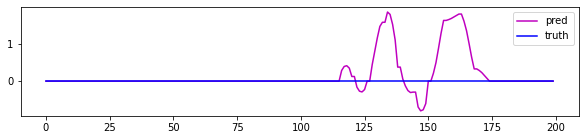

In [18]:
for i in range(1):
    fig = plt.figure(figsize=(10, 2))
    plt.plot(noise_fP_pred[i], color='m', label='pred')
    plt.plot(noise_fP_truth[i], color='blue', label='truth')
    plt.legend()
    plt.show()

In [19]:
max_adc_noise_fP = [max(wave) for wave in noise_fP_pred]

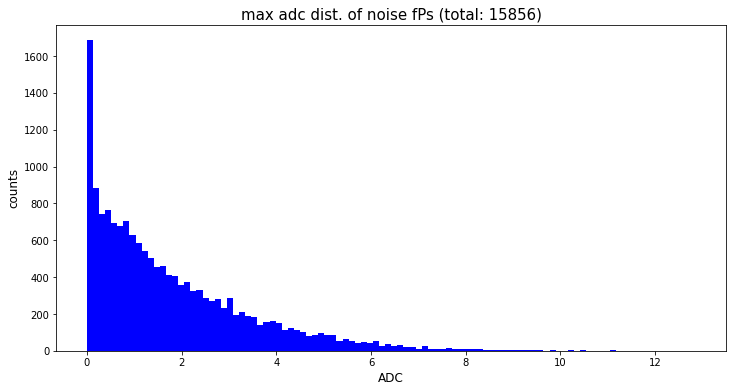

In [20]:
fig = plt.figure(figsize=(12, 6))
plt.hist(max_adc_noise_fP, bins=100, color='blue')
plt.title('max adc dist. of noise fPs (total: ' + str(len(max_adc_noise_fP)) + ')', size=15)
plt.xlabel('ADC', size=12)
plt.ylabel('counts', size=12)
plt.show()

In [21]:
count = sum(1 for val in max_adc_noise_fP if val <= 3)
print(count)

12699


In [22]:
15856-12699

3157

In [ ]:
2169/50000

In [23]:
len(signal_present_pred)

50000

In [24]:
#signal_present_pred
#signal_present_truth

signal_fN_pred = []
signal_fN_truth = []

remain_pred = []
remain_truth = []

for i in range(len(signal_present_pred)):
    if np.std(signal_present_pred[i]) == 0 and np.std(signal_present_truth[i]) != 0:
        signal_fN_pred.append(signal_present_pred[i])
        signal_fN_truth.append(signal_present_truth[i])
    else:
        remain_pred.append(signal_present_pred[i])
        remain_truth.append(signal_present_truth[i])

In [25]:
print(len(signal_fN_pred), len(remain_pred))

3785 46215


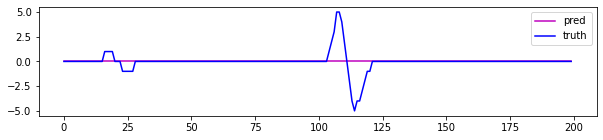

In [26]:
for i in range(1):
    fig = plt.figure(figsize=(10, 2))
    plt.plot(signal_fN_pred[i], color='m', label='pred')
    plt.plot(signal_fN_truth[i], color='blue', label='truth')
    plt.legend()
    plt.show()

In [27]:
max_adc_signal_fN = [max(wave) for wave in signal_fN_truth]

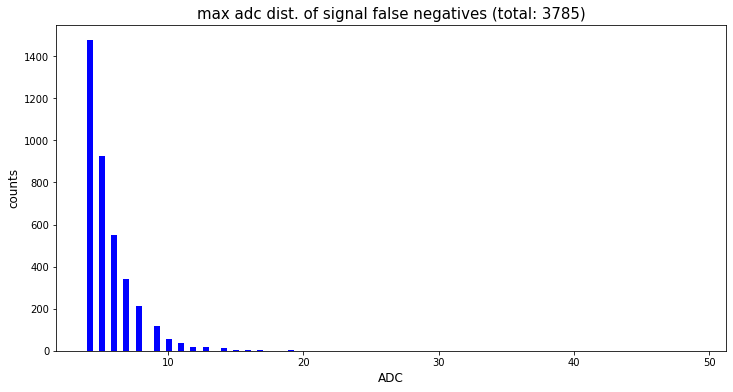

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.hist(max_adc_signal_fN, bins=100, color='blue')
plt.title('max adc dist. of signal false negatives (total: ' + str(len(max_adc_signal_fN)) + ')', size=15)
plt.xlabel('ADC', size=12)
plt.ylabel('counts', size=12)
plt.show()

In [29]:
print(sum(1 for val in max_adc_signal_fN if val < 20))

3781


________________________

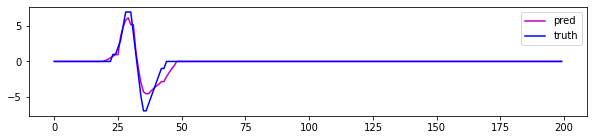

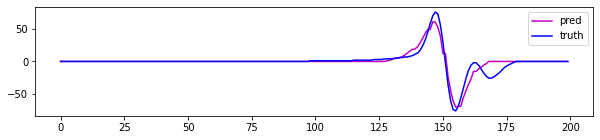

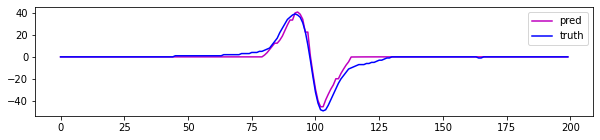

In [30]:
for i in range(3):
    fig = plt.figure(figsize=(10, 2))
    plt.plot(remain_pred[i], color='m', label='pred')
    plt.plot(remain_truth[i], color='blue', label='truth')
    plt.legend()
    plt.show()

In [31]:
max_adcs_remain = [max(wave) for wave in remain_truth]

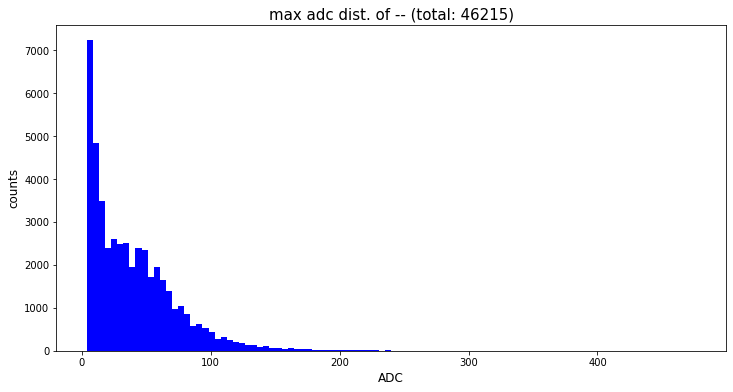

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.hist(max_adcs_remain, bins=100, color='blue')
plt.title('max adc dist. of -- (total: ' + str(len(max_adcs_remain)) + ')', size=15)
plt.xlabel('ADC', size=12)
plt.ylabel('counts', size=12)
plt.show()

In [33]:
print(sum(1 for val in max_adcs_remain if val < 20))

16200


In [34]:
max_adcs_test = [max(wave) for wave in y_test_]

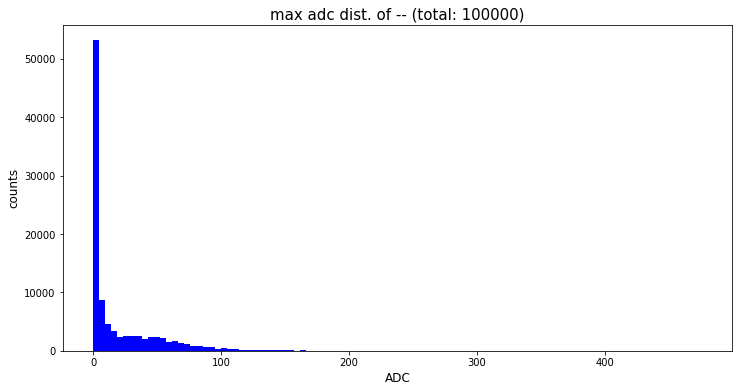

In [35]:
fig = plt.figure(figsize=(12, 6))
plt.hist(max_adcs_test, bins=100, color='blue')
plt.title('max adc dist. of -- (total: ' + str(len(max_adcs_test)) + ')', size=15)
plt.xlabel('ADC', size=12)
plt.ylabel('counts', size=12)
plt.show()

In [36]:
print(sum(1 for val in max_adcs_test if val < 20 and val !=0))

19981


In [37]:
max_adcs_remain_pred = [max(wave) for wave in remain_pred]

In [40]:
len(max_adcs_remain_pred)

46215

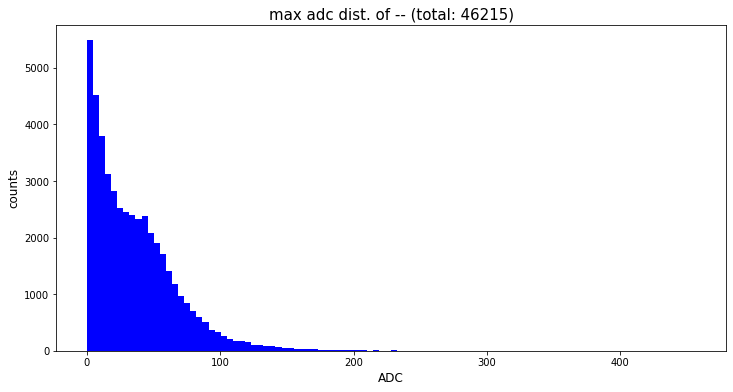

In [38]:
fig = plt.figure(figsize=(12, 6))
plt.hist(max_adcs_remain_pred, bins=100, color='blue')
plt.title('max adc dist. of -- (total: ' + str(len(max_adcs_remain)) + ')', size=15)
plt.xlabel('ADC', size=12)
plt.ylabel('counts', size=12)
plt.show()

In [39]:
count = sum(1 for val in max_adcs_remain_pred if val <= 3)
print(count)

3737


In [41]:
46215-3737

42478